### 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

#### Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END

In [2]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
docs = TextLoader("research_notes.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, embedding_model)
retriever = vectorstore.as_retriever()

In [5]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [6]:
# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [7]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""
Reflect on the following answer to see if it fully addresses the question. 
State YES if it is complete and correct, or NO with an explanation.

Question: {state.question}

Answer: {state.answer}

Respond like:
Reflection: YES or NO
Explanation: ...
"""
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [10]:
def should_continue_reflection(state: RAGReflectionState) -> str:
    """
    Determines the next step after reflection:
    - If answer is good OR max attempts reached -> go to 'done'
    - Otherwise -> go back to 'retriever' for another attempt
    """
    if not state.revised or state.attempts >= 2:
        return "done"
    else:
        return "retriever"

In [8]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

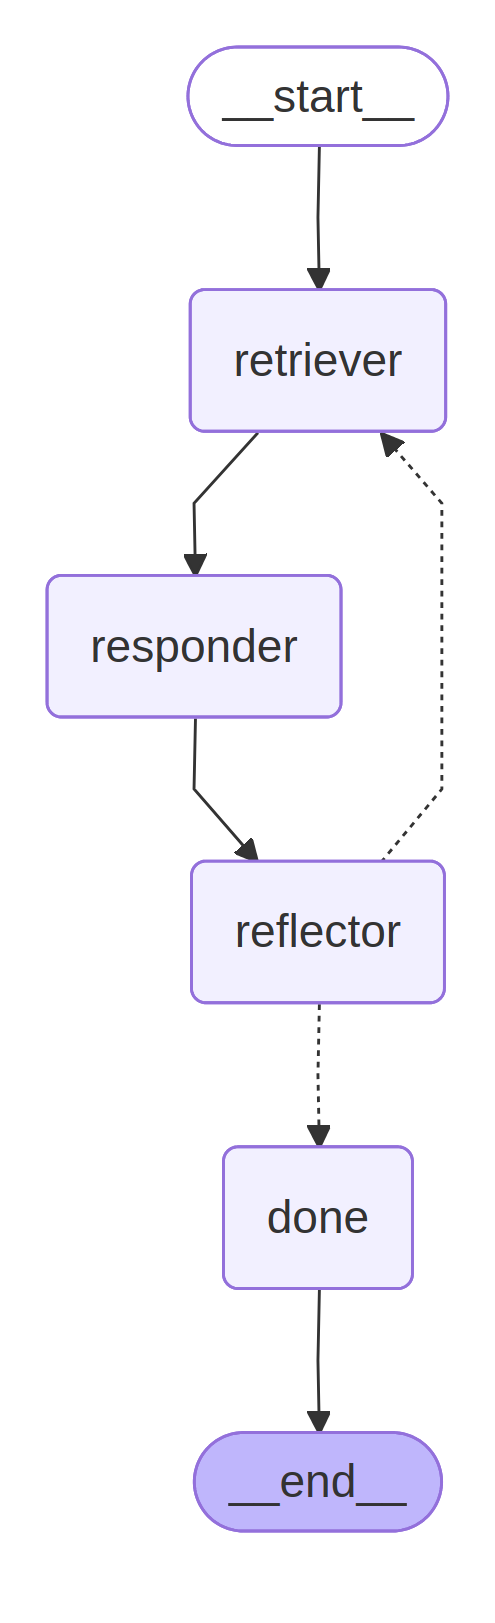

In [11]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()


# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    should_continue_reflection,
    {
        "retriever": "retriever",
        "done": "done"
    }
)

builder.add_edge("done", END)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [13]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "what are the additional experiments in Transformer evaluation?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 The provided context focuses on the evolution and optimization of the Transformer architecture, specifically within the Transformer block itself. It details improvements like grouped-query attention, pre-normalization, and rotary embeddings.

However, the context **does not mention any additional experiments in Transformer evaluation.** It primarily discusses architectural changes and their benefits in terms of scalability, training stability, and generalization.

🔁 Reflection Log:
 Reflection: NO
Explanation: The answer correctly identifies that the provided context doesn't address the question. The question asks about *evaluation* experiments, while the context focuses on *architectural* changes. Therefore, the answer is accurate in stating that the context doesn't provide the requested information.
🔄 Total Attempts: 2
